<a href="https://colab.research.google.com/github/mashnoor3/data-science-portfolio/blob/main/Statistical_modelling_of_football_match_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import altair as alt
from scipy.stats import poisson, skellam

In [4]:
# Install dependendencies to connect to Google Cloud Storage
!pip -q install fsspec # File-system specification
!pip -q install gcsfs # Convenient Filesystem interface over GCS

     |████████████████████████████████| 102kB 4.3MB/s 
     |████████████████████████████████| 1.3MB 7.6MB/s 
     |████████████████████████████████| 143kB 23.6MB/s 
     |████████████████████████████████| 296kB 3.2MB/s 


In [6]:
# Load data from csv file stored in Google Cloud Storage
gs_bucket = 'gs://mashnoor-data-science-portfolio/'
epl_1920 = pd.read_csv(gs_bucket + 'EPL2019-2020.csv', encoding='utf-8')

###Exploratory Data Analysis

We will obtain data from http://football-data.co.uk/englandm.php for the year EPL year 2019-2020.



In [7]:
epl_1920 = epl_1920[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 
                     'HS', 'AS', 'HST', 'AST']]
pd.set_option('display.max_columns', 10)                     

epl_1920 = epl_1920.rename(columns={'FTHG':'HomeGoals', 'FTAG':'AwayGoals', 
                                    'FTR':'Result', 'HS':'HomeShots', 'AS':'AwayShots',
                                    'HST':'HomeShotsOnTarget', 
                                    'AST':'AwayShotsonTarget'})

epl_1920['Date'] = pd.to_datetime(epl_1920['Date'])

print(epl_1920.dtypes)
print(epl_1920.describe())
print(epl_1920.head())

print(epl_1920.apply(lambda x: sum(x.isnull()),axis=0))

# sns.pairplot(epl_1920)

Date                 datetime64[ns]
HomeTeam                     object
AwayTeam                     object
HomeGoals                     int64
AwayGoals                     int64
Result                       object
HomeShots                     int64
AwayShots                     int64
HomeShotsOnTarget             int64
AwayShotsonTarget             int64
dtype: object
        HomeGoals   AwayGoals   HomeShots   AwayShots  HomeShotsOnTarget  \
count  380.000000  380.000000  380.000000  380.000000         380.000000   
mean     1.515789    1.205263   13.323684   11.400000           4.555263   
std      1.248646    1.200252    5.417938    5.255278           2.520543   
min      0.000000    0.000000    2.000000    1.000000           0.000000   
25%      1.000000    0.000000   10.000000    8.000000           3.000000   
50%      1.000000    1.000000   13.000000   11.000000           4.000000   
75%      2.000000    2.000000   16.000000   14.000000           6.000000   
max      8.000000 

###Home vs Away Goals Visualization

To visualize top scoring home and away teams

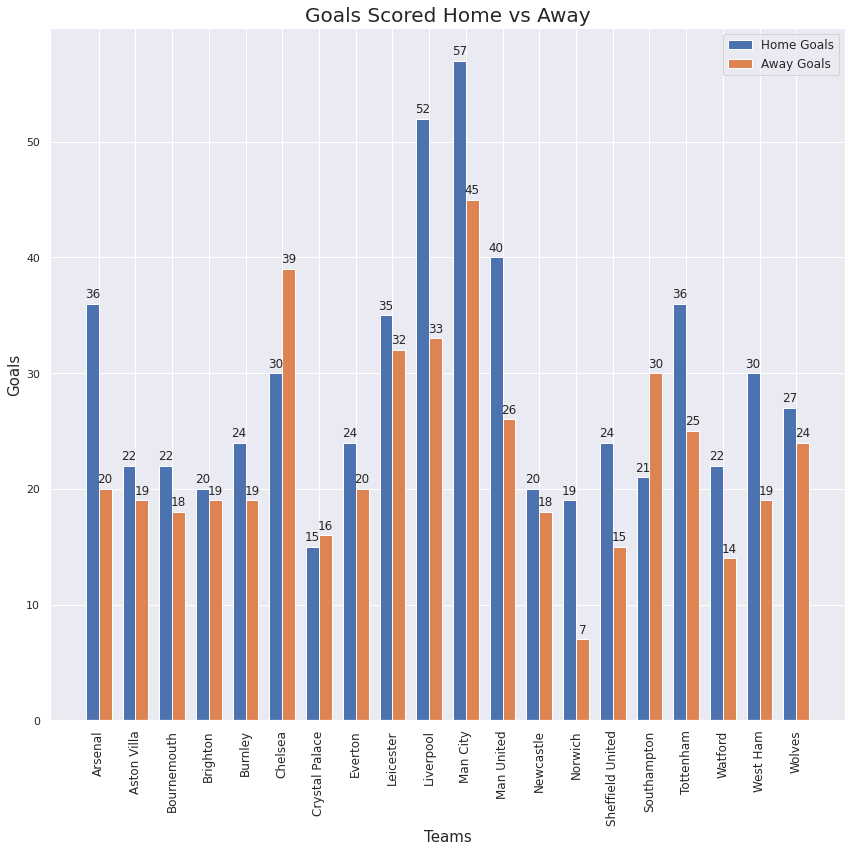

In [ ]:
home_stats = epl_1920.groupby(['HomeTeam'])
away_stats = epl_1920.groupby(['AwayTeam'])

home_stats_sum = home_stats.sum()
away_stats_sum = away_stats.sum()
# print(list(home_stats.groups.keys()))

# plot home and away goals for each team on single bar chart
labels = list(home_stats.groups.keys())
home_goals = list(home_stats_sum.loc[:, 'HomeGoals'])
away_goals = list(away_stats_sum.loc[:, 'AwayGoals'])

x = np.arange(len(labels))
width = 0.35

sns.set_theme()
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, home_goals, width, label='Home Goals')
rects2 = ax.bar(x + width/2, away_goals, width, label='Away Goals')

ax.set_title('Goals Scored Home vs Away', fontsize=20)
ax.set_ylabel('Goals', fontsize=15)
ax.set_xlabel('Teams', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
plt.xticks(rotation=90)
ax.legend(fontsize=12)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12)

autolabel(rects1)
autolabel(rects2)

fig.set_size_inches(12,12)
fig.tight_layout()
plt.show()

###Modelling Home and Away Goals with Poisson Distribution

The Poisson distribution is discrete probability distribution that is used to describe the number of events occuring in a given time period, given the average number of times the event occurs over that time period. Each event is indepedent of the event before it. 

So we can model the number of goals (events) in a given soccer match (90 minutes time period) with a poisson distribution if we make the assumption that the number of goals are not more or less likely by the number of goals already scored in the match. 

Then if we know the average number of games in a match, then the probability of *k* goals being scored can be modelled with the Poisson Distribution. 


$$
P\left( k \right) = \frac{e^{-\lambda} \lambda ^k }{k!}, \lambda>0
$$

Where λ is the expected rate of occurrence, or the average number of goals in a given match. 

First let's plot the number of home and away goals in the 2019-2020 season, and then also model it with Poission distributions. 

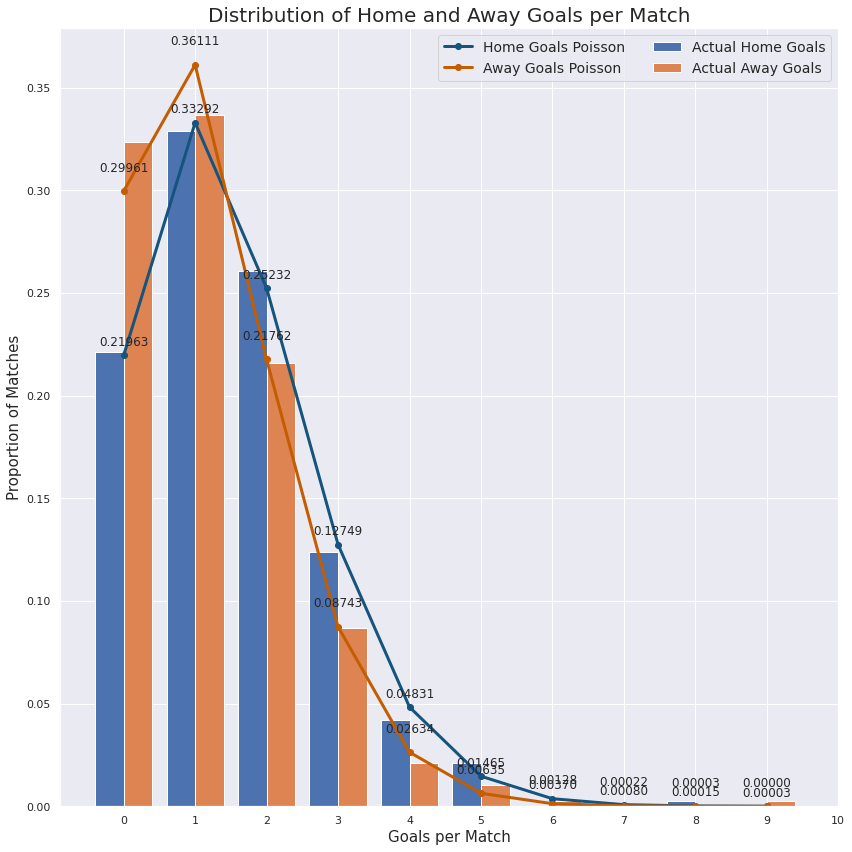

In [ ]:
sns.set_theme()
fig, ax = plt.subplots()

# histogram of home and away goals
num_bins = max(max(epl_1920[['HomeGoals']].values), max(epl_1920[['AwayGoals']].values))
rects1= plt.hist(epl_1920[['HomeGoals','AwayGoals']].values, range(11), 
                 label=['Actual Home Goals', 'Actual Away Goals'], 
                 density=True, align='left')

# poisson arroximation 
avg_home_goals = epl_1920['HomeGoals'].values.mean()
avg_away_goals = epl_1920['AwayGoals'].values.mean()

home_poisson_pred = [poisson.pmf(k, avg_home_goals) for k in range(10)] 
away_poisson_pred = [poisson.pmf(k, avg_away_goals) for k in range(10)] 

# add line plots for poisson approximation 
plt.plot(home_poisson_pred, 'o', linestyle='-', color='#15547D', 
         linewidth=3.0, label='Home Goals Poisson')
plt.plot(away_poisson_pred, 'o', linestyle='-', color='#C45C00', 
         linewidth=3.0, label='Away Goals Poisson')

# add labels for possion estimates 
for x, yh, ya in zip(range(10),home_poisson_pred, away_poisson_pred):
  label_yh = '{:.5f}'.format(yh)
  label_ya = '{:.5f}'.format(ya)
  plt.annotate(label_yh, (x,yh), textcoords='offset points',
               xytext=(0,10),ha='center')
  plt.annotate(label_ya, (x,ya), textcoords='offset points',
               xytext=(0,20),ha='center')

ax.set_title('Distribution of Home and Away Goals per Match', 
             fontsize=20)
ax.set_ylabel('Proportion of Matches', fontsize=15)
ax.set_xlabel('Goals per Match', fontsize=15)
ax.set_xticks(range(11))

ax.legend(fontsize=14, ncol=2)
fig.set_size_inches(12,12)

plt.tight_layout()
plt.show()

Using this model, we can now estimate probability of certain events. For example, the probability of a 2-2 draw can be estimated by:
$$
\begin{align*}
P(2-2\ Draw) &= P(2|Home) \times P(2|Away) \\
        &= 0.252 \times 0.218 \\
        &= 0.055
\end{align*}
$$
Note that we are assuming the number of goals scored by each team are independent events. 
$$
\begin{align*}
P(A\ n \ B) &= P(A) \times P(B)
\end{align*}
$$
Next let us look at the different between home and away goals, ie the outcome of the game; home win, away win, or draw. This will result in the difference between two Poisson distributions, which is the Skellam distribution. 
$$
P\left( k \right) = e^{-(\lambda_1+\lambda_2)^ \frac{k}2} I_k (2 \sqrt{\lambda_1\lambda_2},\ \lambda_1\geq0, \ \lambda_2 \geq 0
$$

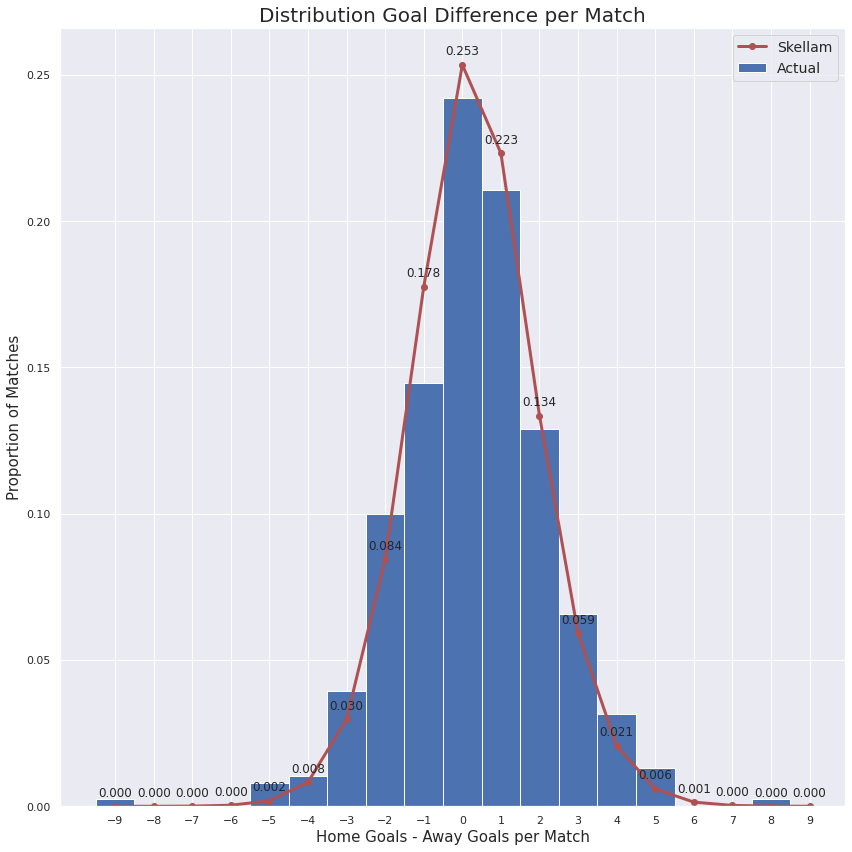

In [ ]:
sns.set_theme()
fig, ax = plt.subplots()

# histogram of difference in goals between home and away
rects1= plt.hist(epl_1920[['HomeGoals']].values - epl_1920[['AwayGoals']].values, 
                 range(-9,10), density=True, align='left', label='Actual')
ax.set_xticks(range(-9,10))

# skellam arroximation 
skellam_pred = [skellam.pmf(k, avg_home_goals, avg_away_goals) for k in range (-9, 10)]

# add line plot for skellam arroximation
plt.plot([i for i in range(-9, 10)],skellam_pred,'o', linestyle='-', color='#AF5052', 
         linewidth=3.0, label='Skellam')

# add labels for skellam estimates 
for x, y in zip(range(-9, 10),skellam_pred):
  label_y = '{:.3f}'.format(y)
  plt.annotate(label_y, (x,y), textcoords='offset points',
               xytext=(0,10),ha='center')

ax.set_title('Distribution Goal Difference per Match', fontsize=20)
ax.set_ylabel('Proportion of Matches', fontsize=15)
ax.set_xlabel('Home Goals - Away Goals per Match', fontsize=15)
ax.set_xticks(range(-9,10))

ax.legend(fontsize=14)
fig.set_size_inches(12,12)

plt.tight_layout()
plt.show()

In [ ]:
def expected_goal_rate(home_or_away, team_name): 
  if home_or_away == 'home':
    goal_distribution = epl_1920[epl_1920['HomeTeam']==team_name][['HomeGoals']].apply(pd.value_counts,normalize=True)
  elif home_or_away == 'away': 
    goal_distribution = epl_1920[epl_1920['AwayTeam']==team_name][['AwayGoals']].apply(pd.value_counts,normalize=True)
  expected_goals = np.sum(np.multiply(goal_distribution.values.T,goal_distribution.index.T))
  return (expected_goals)

liverpool_home_poiss=[poisson.pmf(k, expected_goal_rate('home','Liverpool')) for k in range(10)]
liverpool_away_poiss=[poisson.pmf(k, expected_goal_rate('away','Liverpool')) for k in range(10)]

norwich_home_poiss=[poisson.pmf(k, expected_goal_rate('home','Norwich')) for k in range(10)]
norwich_home_poiss=[poisson.pmf(k, expected_goal_rate('away','Norwich')) for k in range(10)]

# building multi-plot grids to visualize home and away goals for two teams
